# Introduction

Course: Deep Learing

Author: Oai Tran

Institution: University of Virginia — School of Data Science

Date: 11/07/2025

Notebook Type: Educational / Research — End-to-End Implementation


## Overview
This notebook is the end-to-end process of the final project. The goal of the final project is to predict a stock price and determine whether it is a buy/sell/hold position. 

LW


#### Stage 1

In [1]:
# ==========================================================
#  Stage 1 — LW Forecast (v2.6)
#  Δ-Target + Conv1D→LSTM + Macro (VIX) | CuDNN-safe & Merge-Safe
# ==========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
import os
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from datetime import datetime, timedelta


In [2]:

# ----------------------------------------------------------
# 0. Reproducibility & environment setup
# ----------------------------------------------------------
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_USE_CUDNN_RNN"] = "0"   # disable CuDNN RNN kernels
print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [3]:

# ----------------------------------------------------------
# 1. Load data (LW + VIX)
# ----------------------------------------------------------
start_date, end_date = "2017-01-01", "2025-09-10"

raw = yf.Ticker("LW").history(start=start_date, end=end_date, auto_adjust=False)
vix_raw = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)

raw = raw[["Open", "High", "Low", "Close", "Volume"]].dropna()
vix_raw = vix_raw[["Close"]].rename(columns={"Close": "VIX_Close"}).dropna()

# ----------------------------------------------------------
# 1.5 Align and clean data
# ----------------------------------------------------------
# Outer join → keep all dates; forward-fill VIX; drop non-trading days for VOO
df = raw.join(vix_raw, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

print(f"After merge: {df.shape[0]} rows remain ({df.index.min().date()} → {df.index.max().date()})")



After merge: 2183 rows remain (2017-01-03 → 2025-09-09)


/tmp/ipykernel_460486/232545362.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")


/home/dzn7nf/.local/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


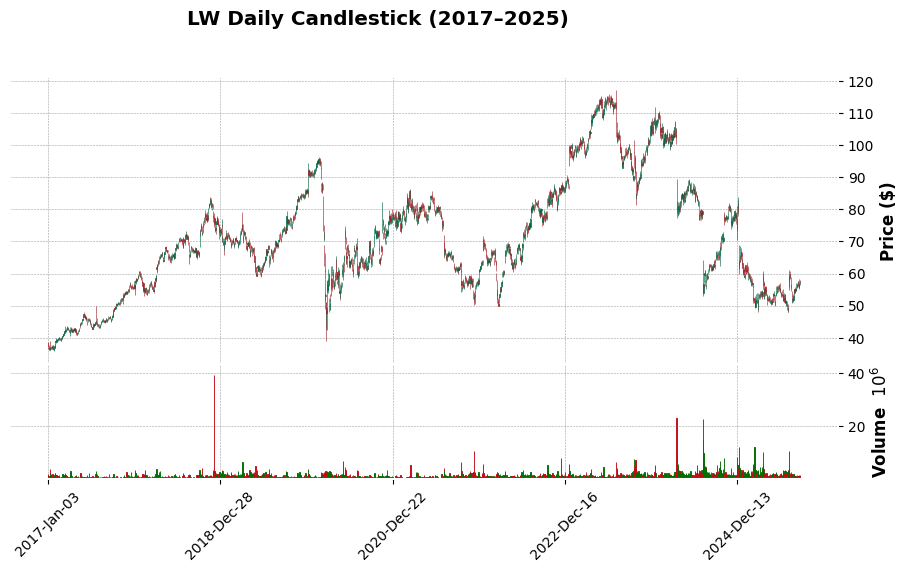

In [4]:
mpf.plot(
    raw,
    type="candle", 
    style="charles",   # clean style
    title="LW Daily Candlestick (2017–2025)",
    ylabel="Price ($)",
    volume=True,       # adds volume below chart
    figratio=(12,6)
)

In [5]:
# ----------------------------------------------------------
# 2. Feature engineering
# ----------------------------------------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, min_periods=1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"] - df["VIX_Close"].rolling(20, min_periods=1).mean()) / \
                     df["VIX_Close"].rolling(20, min_periods=1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)



In [6]:
# ----------------------------------------------------------
# 3. Target = next-day return (Δ target)
# ----------------------------------------------------------
df["TargetRet1"] = (df["Close"].shift(-1) / df["Close"] - 1.0)
df["PrevClose"]  = df["Close"]
df = df.dropna(subset=["TargetRet1"]).copy()


In [7]:
# ----------------------------------------------------------
# 4. Scale features only (not target)
# ----------------------------------------------------------
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols, index=df.index)

y_all      = df["TargetRet1"].values.astype("float32")
prev_close = df["PrevClose"].values.astype("float32")
dates_all  = df.index

print(f"Scaled features shape: {scaled_df.shape}")



Scaled features shape: (2182, 10)


In [8]:
# ----------------------------------------------------------
# 5. Sequence builder
# ----------------------------------------------------------
def make_sequences(X_df, y, prev_close, dates, window=12):
    X, y_out, prev_c, d_out = [], [], [], []
    for i in range(len(X_df) - window):
        X.append(X_df.iloc[i:i+window].values)
        y_out.append(y[i+window-1])           # predict ΔClose for t+1
        prev_c.append(prev_close[i+window-1]) # previous close
        d_out.append(dates[i+window])         # target date
    return np.array(X), np.array(y_out), np.array(prev_c), np.array(d_out)

window = 12
X, y, prev_c, dts = make_sequences(scaled_df, y_all, prev_close, dates_all, window=window)
split = int(len(X)*0.8)

X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]
pc_tr, pc_te = prev_c[:split], prev_c[split:]
dt_tr, dt_te = dts[:split], dts[split:]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}")



Train: (1736, 12, 10),  Test: (434, 12, 10)


In [9]:
# ----------------------------------------------------------
# 6. Conv1D → LSTM model (CuDNN-safe)
# ----------------------------------------------------------
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True, unroll=True,
             activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        LSTM(32, unroll=True, activation='tanh', recurrent_activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next-day return
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt, loss='mse')
    return model

model = build_model((window, X_tr.shape[2]))
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=120,
    batch_size=16,
    verbose=1,
    callbacks=[es]
)



'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/120


W0000 00:00:1763569580.356136  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.373101  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.393454  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.395945  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.400274  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.424594  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.424749  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.427007  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569580.427096  460585 gp

  1/109 [..............................] - ETA: 8:38 - loss: 0.0022

W0000 00:00:1763569582.972754  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569582.989868  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569582.998934  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569582.999024  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.005888  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.006021  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.006116  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.010460  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.010542  460585 gp

 36/109 [========>.....................] - ETA: 0s - loss: 5.0361e-04

W0000 00:00:1763569583.180291  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180364  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180429  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180509  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180574  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180642  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180712  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180770  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.180836  460585 gp

109/109 [==============================] - ETA: 0s - loss: 4.1796e-04

W0000 00:00:1763569583.657900  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658286  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658345  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658420  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658509  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658576  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658652  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658716  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569583.658784  460585 gp

109/109 [==============================] - 6s 10ms/step - loss: 4.1796e-04 - val_loss: 8.2130e-04
Epoch 2/120
  1/109 [..............................] - ETA: 0s - loss: 3.1253e-04

W0000 00:00:1763569584.033615  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.049616  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.049714  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.049820  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.049918  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.049986  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.050061  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.050133  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.050210  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1820e-04 - val_loss: 8.2810e-04
Epoch 3/120
 18/109 [===>..........................] - ETA: 0s - loss: 4.8040e-04

W0000 00:00:1763569584.537734  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538125  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538183  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538258  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538338  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538412  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538495  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538564  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569584.538632  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1125e-04 - val_loss: 8.6080e-04
Epoch 4/120
 35/109 [========>.....................] - ETA: 0s - loss: 4.1872e-04

W0000 00:00:1763569585.033593  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.033974  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034052  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034119  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034190  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034258  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034325  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034391  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.034469  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1539e-04 - val_loss: 8.2105e-04
Epoch 5/120
 35/109 [========>.....................] - ETA: 0s - loss: 3.5625e-04

W0000 00:00:1763569585.449879  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.449972  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450046  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450113  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450183  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450250  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450316  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450382  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.450457  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1415e-04 - val_loss: 8.2541e-04
Epoch 6/120
 32/109 [=======>......................] - ETA: 0s - loss: 4.3332e-04

W0000 00:00:1763569585.868670  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.868771  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.868847  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.868914  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.868987  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.869053  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.869119  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.869186  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569585.869254  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1121e-04 - val_loss: 8.2973e-04
Epoch 7/120
 35/109 [========>.....................] - ETA: 0s - loss: 4.4904e-04

W0000 00:00:1763569586.305371  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305473  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305549  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305615  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305688  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305757  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305824  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305891  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569586.305960  460585 gp

109/109 [==============================] - 0s 4ms/step - loss: 4.1335e-04 - val_loss: 8.3429e-04
Epoch 8/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1190e-04 - val_loss: 8.2512e-04
Epoch 9/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1172e-04 - val_loss: 8.4142e-04
Epoch 10/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1257e-04 - val_loss: 8.5470e-04
Epoch 11/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1694e-04 - val_loss: 8.2071e-04
Epoch 12/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1140e-04 - val_loss: 8.4455e-04
Epoch 13/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1046e-04 - val_loss: 8.2494e-04
Epoch 14/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1168e-04 - val_loss: 8.2623e-04
Epoch 15/120
109/109 [==============================] - 0s 4ms/step - loss: 4.1211e-04 - val_loss: 8.2428e-04
Epoch 16/120
109/109 [===

In [10]:
# ----------------------------------------------------------
# 7. Predict → reconstruct prices
# ----------------------------------------------------------
y_pred_ret = model.predict(X_te).flatten()
y_pred_price = pc_te * (1.0 + y_pred_ret)
y_true_price = pc_te * (1.0 + y_te)

# ----------------------------------------------------------
# 8. Metrics
# ----------------------------------------------------------
mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
mae  = mean_absolute_error(y_true_price, y_pred_price)
rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
r2   = r2_score(y_true_price, y_pred_price)

print(f"MAPE={mape:.2f}% | MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.3f}")



14/14 [==============================] - 0s 4ms/step
MAPE=1.65% | MAE=$1.13 | RMSE=$2.13 | R²=0.987


W0000 00:00:1763569592.109526  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109613  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109669  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109742  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109828  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109893  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.109966  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.110036  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569592.110107  460585 gp

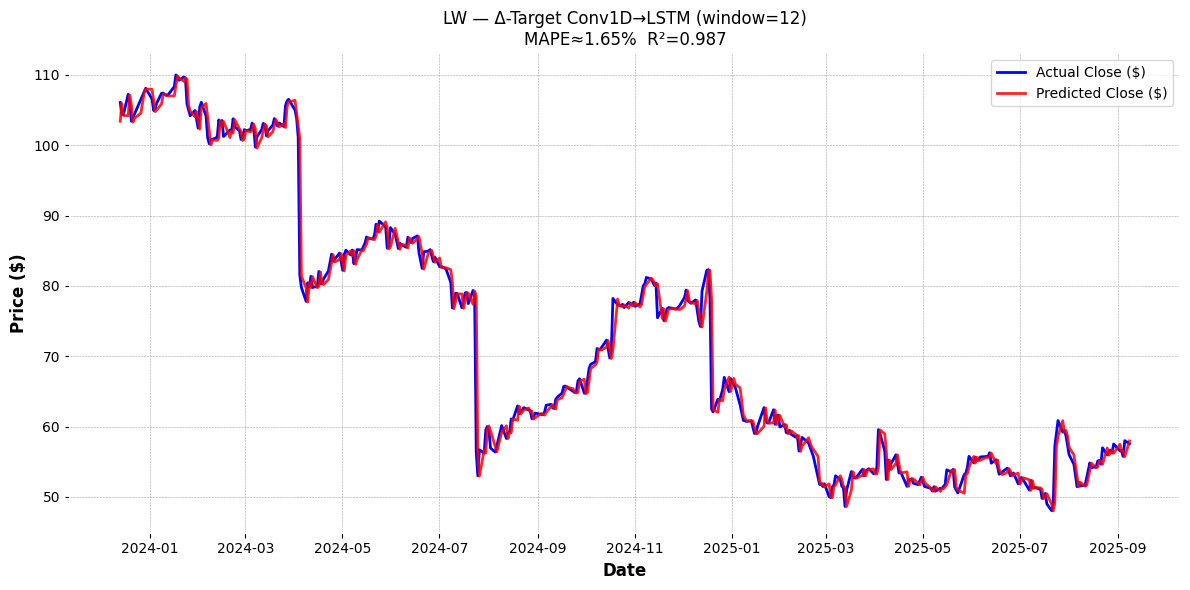

In [11]:
# ----------------------------------------------------------
# 8. Plot results
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(dt_te, y_true_price, label="Actual Close ($)", color="blue")
plt.plot(dt_te, y_pred_price, label="Predicted Close ($)", color="red", alpha=0.85)
plt.title(f"LW — Δ-Target Conv1D→LSTM (window={window})\nMAPE≈{mape:.2f}%  R²={r2:.3f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 9. Save model + scaler
# ----------------------------------------------------------
os.makedirs("models", exist_ok=True)
model.save("models/LW_stage1_v26.h5")
joblib.dump(scaler, "models/LW_scaler_v26.pkl")
print("Model & scaler saved to ./models/")

Model & scaler saved to ./models/


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Stage 2

W0000 00:00:1763569593.036636  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.036723  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.036777  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.036850  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.036935  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.037000  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.037073  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.037142  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569593.037212  460585 gp

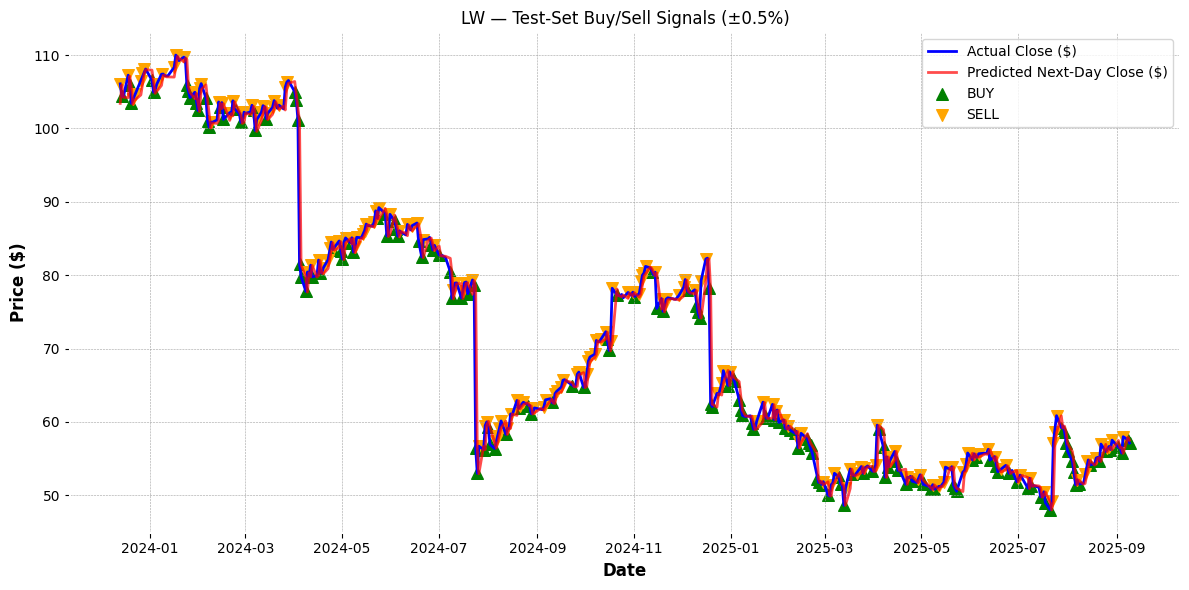

=== TEST-SET RESULTS ===
Strategy  → CAGR -87.96%, Vol 34.66%, Sharpe -2.54
Buy&Hold → CAGR -29.15%, Vol 45.51%, Sharpe -0.64


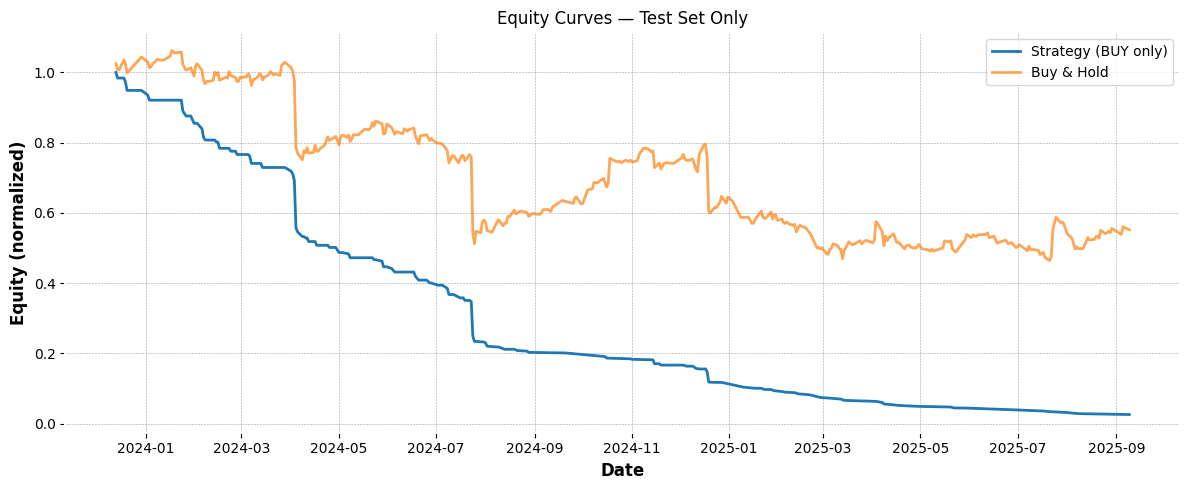


Recent test-period signals:
                              Actual  Predicted    Gap(%) Signal
2025-08-26 04:00:00+00:00  56.410000  55.939162 -0.834671   SELL
2025-08-27 04:00:00+00:00  56.660000  56.366569 -0.517880   SELL
2025-08-28 04:00:00+00:00  56.250000  56.615164  0.649181    BUY
2025-08-29 04:00:00+00:00  57.529999  56.205281 -2.302656   SELL
2025-09-02 04:00:00+00:00  56.549999  57.484224  1.652034    BUY
2025-09-03 04:00:00+00:00  56.549999  56.505123 -0.079358   HOLD
2025-09-04 04:00:00+00:00  55.770000  56.505406  1.318639    BUY
2025-09-05 04:00:00+00:00  58.000000  55.725759 -3.921105   SELL
2025-09-08 04:00:00+00:00  57.570000  57.954004  0.667021    BUY
2025-09-09 04:00:00+00:00  57.119999  57.524039  0.707353    BUY
Saved: artifacts/stage2_signals_LW.csv
Saved: models/stage2_config_LW.pkl
Saved placeholder model: models/stage2_direct_signal_placeholder_LW.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# ==========================================================
#  Stage 2 (Direct Signal, Test Only)
#  v2.4 — Plot & Backtest only on Stage-1 test split
# ==========================================================




# ----------------------------
# Config
# ----------------------------
TICKER = "LW"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 12
THRESH = 0.005   # 0.5% price gap threshold for Buy/Sell
TEST_RATIO = 0.2


# ----------------------------
# Load price data ( + VIX)
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
voo = voo[["Open","High","Low","Close","Volume"]].dropna()
vix = vix[["Close"]].rename(columns={"Close":"VIX_Close"}).dropna()

df = voo.join(vix, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# ----------------------------
# Load Stage-1 model + scaler
# ----------------------------
model_path = "models/LW_stage1_v26.h5"
scaler_path = "models/LW_scaler_v26.pkl"
assert os.path.exists(model_path), "Stage-1 model not found!"
assert os.path.exists(scaler_path), "Stage-1 scaler not found!"

model = tf.keras.models.load_model(model_path, compile=False)
scaler = joblib.load(scaler_path)

# ----------------------------
# Feature engineering (same schema)
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20,1).mean()) / df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open","High","Low","Close","Volume",
    "Ret1","Momentum5","Volatility5","LogVolume","VIX_Z"
]
scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Build rolling input windows
# ----------------------------
def make_seq(Xdf, window=WINDOW):
    Xs, dates = [], []
    for i in range(len(Xdf)-window):
        Xs.append(Xdf.iloc[i:i+window].values)
        dates.append(Xdf.index[i+window])
    return np.array(Xs), np.array(dates)

Xseq, dates = make_seq(scaled_df, window=WINDOW)
pred_ret = model.predict(Xseq, verbose=0).flatten()

# ----------------------------
# Reconstruct predicted prices
# ----------------------------
close_vals = df["Close"].values
pred_price = close_vals[WINDOW-1:-1] * (1 + pred_ret)
actual_price = close_vals[WINDOW:]
dates = np.array(dates)

# ----------------------------
# Split train/test (chronological)
# ----------------------------
split_idx = int(len(pred_price)*(1-TEST_RATIO))
pred_price_test = pred_price[split_idx:]
actual_price_test = actual_price[split_idx:]
dates_test = dates[split_idx:]

# ----------------------------
# Generate BUY / SELL / HOLD on test only
# ----------------------------
gap = (pred_price_test - actual_price_test) / actual_price_test
signals = np.zeros_like(pred_price_test)
signals[gap > THRESH]  = 1    # BUY
signals[gap < -THRESH] = -1   # SELL
signal_labels = np.where(signals==1,"BUY",np.where(signals==-1,"SELL","HOLD"))

df_signals = pd.DataFrame({
    "Actual": actual_price_test,
    "Predicted": pred_price_test,
    "Gap(%)": gap*100,
    "Signal": signal_labels
}, index=dates_test)

# ----------------------------
# Plot (TEST only)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_signals.index, df_signals["Actual"], label="Actual Close ($)", color="blue")
plt.plot(df_signals.index, df_signals["Predicted"], label="Predicted Next-Day Close ($)", color="red", alpha=0.7)
plt.scatter(df_signals.index[df_signals["Signal"]=="BUY"], df_signals["Actual"][df_signals["Signal"]=="BUY"], 
            marker="^", color="green", label="BUY", s=70)
plt.scatter(df_signals.index[df_signals["Signal"]=="SELL"], df_signals["Actual"][df_signals["Signal"]=="SELL"], 
            marker="v", color="orange", label="SELL", s=70)
plt.title(f"{TICKER} — Test-Set Buy/Sell Signals (±{THRESH*100:.1f}%)")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ----------------------------
# Simple backtest (TEST only)
# ----------------------------
returns = pd.Series(df["Close"]).pct_change().reindex(df_signals.index).fillna(0)
positions = np.where(df_signals["Signal"]=="BUY", 1.0, 0.0)
strategy_returns = returns * positions
eq_curve = (1 + strategy_returns).cumprod()
bh_curve = (1 + returns).cumprod()

def ann_metrics(r):
    cagr = (1.0 + r).prod() ** (252/len(r)) - 1.0
    vol  = r.std() * np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    return cagr, vol, sharpe

cagr_s, vol_s, sh_s = ann_metrics(strategy_returns)
cagr_b, vol_b, sh_b = ann_metrics(returns)

print(f"=== TEST-SET RESULTS ===")
print(f"Strategy  → CAGR {cagr_s:.2%}, Vol {vol_s:.2%}, Sharpe {sh_s:.2f}")
print(f"Buy&Hold → CAGR {cagr_b:.2%}, Vol {vol_b:.2%}, Sharpe {sh_b:.2f}")

plt.figure(figsize=(12,5))
plt.plot(eq_curve.index, eq_curve.values, label="Strategy (BUY only)")
plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curves — Test Set Only")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("\nRecent test-period signals:")
print(df_signals.tail(10))


os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# 1 Save signal dataframe (test predictions)
df_signals.to_csv("artifacts/stage2_signals_LW.csv")
print("Saved: artifacts/stage2_signals_LW.csv")

# 2 Save the rule parameters as a tiny dict (so we can reload later)
stage2_config = {
    "ticker": TICKER,
    "window": WINDOW,
    "threshold": THRESH,
    "test_ratio": TEST_RATIO,
    "feature_cols": feature_cols,
    "metrics": {
        "strategy_cagr": float(cagr_s),
        "strategy_vol":  float(vol_s),
        "strategy_sharpe": float(sh_s)
    }
}
joblib.dump(stage2_config, "models/stage2_config_LW.pkl")
print("Saved: models/stage2_config_LW.pkl")

# 3 Optional: save a lightweight “direct-signal model” placeholder
# (just to mark this stage so ensemble loader can find it)
placeholder = Sequential([Dense(1, input_shape=(1,))])
placeholder.save("models/stage2_direct_signal_placeholder_LW.h5")
print("Saved placeholder model: models/stage2_direct_signal_placeholder_LW.h5")



In [14]:
# ==========================================================
#  Stage 2 — CNN + SVM Training and Save
# ==========================================================

# ----------------------------
# Config
# ----------------------------
#TICKER = "VOO"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 7
EPOCHS, BATCH = 40, 32
os.makedirs("models", exist_ok=True)

# ----------------------------
# Load LW + VIX
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
df = voo.join(vix[["Close"]].rename(columns={"Close":"VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df[["Open","High","Low","Close","Volume","VIX_Close"]].dropna()

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"]-df["VIX_Close"].rolling(20,1).mean())/df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)

features = ["Open","High","Low","Close","Volume","Ret1","Momentum5",
            "Volatility5","LogVolume","VIX_Z"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# ----------------------------
# Build CNN “images” and labels
# ----------------------------
def make_seq(df_scaled, horizon=1, window=WINDOW):
    X, y = [], []
    closes = df["Close"].values
    for i in range(len(df_scaled)-window-horizon):
        X.append(df_scaled.iloc[i:i+window].values.T)
        fwd_ret = (closes[i+window+horizon-1]-closes[i+window-1]) / closes[i+window-1]
        y.append(1 if fwd_ret>0 else 0)  # 1=Up, 0=Down
    return np.array(X), np.array(y)

X, y = make_seq(scaled_df)
X = X[..., np.newaxis]
print("Dataset:", X.shape, y.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# CNN model
# ----------------------------
inp = Input(shape=(X.shape[1], X.shape[2], 1))
x = Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(2, activation="softmax")(x)

cnn = Model(inp, out)
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
es = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
cnn.fit(Xtr, ytr, validation_data=(Xte, yte),
        epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)

cnn.save("models/stage2_cnn_LW.h5")
print("Saved: models/stage2_cnn_LW.h5")

# ----------------------------
# SVM on CNN embeddings
# ----------------------------
embed_model = Model(inputs=cnn.input, outputs=cnn.layers[-3].output)
emb_tr = embed_model.predict(Xtr, verbose=0)
emb_te = embed_model.predict(Xte, verbose=0)

svm = SVC(kernel="rbf", probability=True)
svm.fit(emb_tr, ytr)
acc = svm.score(emb_te, yte)
print(f"SVM accuracy: {acc:.3f}")
joblib.dump(svm, "models/stage2_svm_LW.pkl")
print("Saved: models/stage2_svm_LW.pkl")


Dataset: (2174, 10, 7, 1) (2174,)
Epoch 1/40


W0000 00:00:1763569594.723124  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.723985  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.726974  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.727076  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.727148  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.727225  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.727289  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.727397  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569594.750655  460585 gp

39/55 [====================>.........] - ETA: 0s - loss: 0.9560 - accuracy: 0.5345

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763569595.431760  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432020  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432091  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432184  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432253  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432330  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.432393  460585 gpu_timer.cc:114] Skipping

55/55 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.5290

W0000 00:00:1763569595.633153  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633241  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633298  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633368  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633441  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633538  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633615  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633701  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.633782  460585 gp

55/55 [==============================] - 2s 9ms/step - loss: 0.8819 - accuracy: 0.5290 - val_loss: 0.6949 - val_accuracy: 0.5011
Epoch 2/40
35/55 [==================>...........] - ETA: 0s - loss: 0.6923 - accuracy: 0.5321

W0000 00:00:1763569595.881964  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882051  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882110  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882182  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882246  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882334  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882410  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882509  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569595.882591  460585 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5239 - val_loss: 0.7017 - val_accuracy: 0.4966
Epoch 3/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6932 - accuracy: 0.5116

W0000 00:00:1763569596.105033  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105250  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105310  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105366  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105422  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105498  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105587  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105664  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.105740  460585 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5221 - val_loss: 0.7077 - val_accuracy: 0.4966
Epoch 4/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6920 - accuracy: 0.5203

W0000 00:00:1763569596.310525  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310587  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310643  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310697  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310767  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310855  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.310931  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.311008  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.311084  460585 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6909 - accuracy: 0.5221 - val_loss: 0.7049 - val_accuracy: 0.4943
Epoch 5/40
43/55 [======================>.......] - ETA: 0s - loss: 0.6940 - accuracy: 0.4993

W0000 00:00:1763569596.516371  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516472  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516528  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516584  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516657  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516728  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516801  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516872  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569596.516949  460585 gp

55/55 [==============================] - 0s 3ms/step - loss: 0.6896 - accuracy: 0.5112 - val_loss: 0.7061 - val_accuracy: 0.4966
Epoch 6/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5221 - val_loss: 0.7017 - val_accuracy: 0.4874
Epoch 7/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.5250 - val_loss: 0.6955 - val_accuracy: 0.5011
Saved: models/stage2_cnn_LW.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SVM accuracy: 0.503
Saved: models/stage2_svm_LW.pkl


### Stage 3

In [15]:
# ==========================================================
#  Predict next-day open and close price + signal
#  Interactive Jupyter version
# ==========================================================


# ----------------------------
# Config
# ----------------------------
VIX = "^VIX"
WINDOW_LSTM = 12
WINDOW_CNN = 7
THRESH = 0.02  # 2% threshold for signal
LOOKBACK = 200  # days before target date for context

# ----------------------------
# Ask user inputs
# ----------------------------
ticker = input("Enter stock ticker (e.g., VOO, AAPL, MSFT): ").strip().upper()
while True:
    date_str = input("Enter date (YYYY-MM-DD): ").strip()
    try:
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        break
    except ValueError:
        print("Invalid format. Please use YYYY-MM-DD (e.g., 2025-11-06).")

# ----------------------------
# Load models
# ----------------------------
stage1_path = "models/LW_stage1_v26.h5"
scaler_path = "models/LW_scaler_v26.pkl"
cnn_path = "models/stage2_cnn_LW.h5"
svm_path = "models/stage2_svm_LW.pkl"

assert os.path.exists(stage1_path), "Missing Stage 1 model"
assert os.path.exists(scaler_path), "Missing Stage 1 scaler"
model_stage1 = tf.keras.models.load_model(stage1_path, compile=False)
scaler = joblib.load(scaler_path)

cnn_model, svm = None, None
if os.path.exists(cnn_path) and os.path.exists(svm_path):
    cnn_model = tf.keras.models.load_model(cnn_path, compile=False)
    svm = joblib.load(svm_path)

# ----------------------------
# Load price data
# ----------------------------
start_date = (target_date - timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
end_date = (target_date + timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} and VIX data up to {target_date.date()}...")
stock = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker(VIX).history(start=start_date, end=end_date, auto_adjust=False)

if stock.empty:
    raise ValueError(f"No data found for {ticker}. Check the ticker symbol.")

df = stock.join(vix[["Close"]].rename(columns={"Close": "VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"] = df["Close"].pct_change().fillna(0.0)
df["Momentum5"] = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, 1).std().fillna(0.0)
df["LogVolume"] = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20, 1).mean()) / df["VIX_Close"].rolling(20, 1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Stage 1 — LSTM price predictions (Open + Close)
# ----------------------------
X_last = scaled_df.iloc[-WINDOW_LSTM:].values.reshape(1, WINDOW_LSTM, -1)

# predict close
pred_ret_close = model_stage1.predict(X_last, verbose=0).flatten()[0]
pred_close_price = df["Close"].iloc[-1] * (1 + pred_ret_close)

# predict open (shift features by 1 day to simulate next open)
X_last_shifted = scaled_df.iloc[-(WINDOW_LSTM+1):-1].values.reshape(1, WINDOW_LSTM, -1)
pred_ret_open = model_stage1.predict(X_last_shifted, verbose=0).flatten()[0]
pred_open_price = df["Open"].iloc[-1] * (1 + pred_ret_open)

print(f"Stage 1 predicts:")
print(f"   → Next Open ≈ ${pred_open_price:.2f} ({pred_ret_open*100:.3f}% change)")
print(f"   → Next Close ≈ ${pred_close_price:.2f} ({pred_ret_close*100:.3f}% change)")

# ----------------------------
# Stage 2 — CNN + SVM direction signal (if available)
# ----------------------------
stage2_signal, cnn_conf = 0, 0.0
if cnn_model and svm:
    cnn_input = scaled_df.iloc[-WINDOW_CNN:].values.T.reshape(1, len(feature_cols), WINDOW_CNN, 1)

    cnn_embed_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
    cnn_embed = cnn_embed_model.predict(cnn_input, verbose=0)

    cnn_logits = cnn_model.predict(cnn_input, verbose=0)
    cnn_pred = np.argmax(cnn_logits, axis=1)[0]
    cnn_conf = cnn_logits[0][cnn_pred]

    stage2_signal = svm.predict(cnn_embed)[0]
    stage2_signal = 1 if stage2_signal == 1 else -1
    print(f"Stage 2 predicts: {'BUY' if stage2_signal==1 else 'SELL'} (conf={cnn_conf:.2f})")
else:
    print("Stage 2 not available — using Stage 1 only.")

# ----------------------------
# Combine predictions → Final Signal
# ----------------------------
if stage2_signal == 1 and pred_ret_close > THRESH:
    action = "BUY"
elif stage2_signal == -1 and pred_ret_close < -THRESH:
    action = "SELL"
elif abs(pred_ret_close) < THRESH / 2:
    action = "HOLD"
else:
    action = "BUY" if pred_ret_close > 0 else "SELL"




Enter stock ticker (e.g., VOO, AAPL, MSFT):  LW
Enter date (YYYY-MM-DD):  2025-11-03


Fetching LW and VIX data up to 2025-11-03...


W0000 00:00:1763569607.630992  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631081  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631135  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631207  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631294  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631358  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631431  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631508  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.631578  460585 gp

Stage 1 predicts:
   → Next Open ≈ $61.48 (-0.104% change)
   → Next Close ≈ $62.70 (-0.101% change)
Stage 2 predicts: BUY (conf=0.53)


W0000 00:00:1763569607.842063  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842154  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842214  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842287  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842350  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842441  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842524  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842615  460585 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763569607.842695  460585 gp

In [16]:
# ----------------------------
# Display final result
# ----------------------------
print("\nFINAL PREDICTION RESULT")
print(f"Ticker: {ticker}")
print(f"Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Latest available close: ${df['Close'].iloc[-1]:.2f}")
print(f"Predicted next OPEN: ${pred_open_price:.2f}")
print(f"Predicted next CLOSE: ${pred_close_price:.2f}")
print(f"Predicted return: {pred_ret_close*100:.3f}%")
print(f"Signal: {'BUY' if action=='BUY' else ('SELL' if action=='SELL' else 'HOLD')}")


FINAL PREDICTION RESULT
Ticker: LW
Date: 2025-11-03
Latest available close: $62.76
Predicted next OPEN: $61.48
Predicted next CLOSE: $62.70
Predicted return: -0.101%
Signal: HOLD
